In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50 as an example for ViT alternative
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)


2025-03-04 07:40:40.449000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 07:40:41.024436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMG_SIZE = 48  # FER2013 image size
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(EMOTION_FOLDERS)  # 7 emotion classes

In [3]:
# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

I0000 00:00:1741074042.934648 3222239 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741074043.089354 3222337 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [4]:
lock = threading.Lock()

def detect_and_crop_face(image):
    """Detects and crops the face using MediaPipe BlazeFace, then resizes to target size."""
    with lock:
        if image is None:
            print("Empty image")
            return None
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
                
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
                
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))

        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741074043.144911 3222330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
def image_generator(dataframe, batch_size=32):
    """Loads images from DataFrame and yields batches."""
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = row["path"]  # Use path from DataFrame
            label = row["label"]  # Use label from DataFrame
            
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face / 255.0)  # Normalize pixel values
                batch_labels.append(to_categorical(label, num_classes=num_classes))

            if len(batch_images) == batch_size:
                yield np.array(batch_images), np.array(batch_labels)
                batch_images, batch_labels = [], []

        # Yield remaining images
        if batch_images:
            yield np.array(batch_images), np.array(batch_labels)


In [6]:
# Identity Normalization (Idn) Module with Batch Normalization
def create_identity_normalization():
    inputs = keras.Input(shape=(48, 48, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return keras.Model(inputs, x, name="IdentityNormalization")

# Mixture of Experts (MoE) Module with Improved Gating
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor with Dropout
def create_cnn_feature_extractor():
    inputs = keras.Input(shape=(48, 48, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor")

# Transformer Feature Extractor using ResNet50
def create_transformer_feature_extractor():
    inputs = keras.Input(shape=(48, 48, 3))
    base_model = ResNet50(input_shape=(48, 48, 3), include_top=False, weights="imagenet")(inputs)
    x = layers.GlobalAveragePooling2D()(base_model)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return keras.Model(inputs, x, name="TransformerFeatureExtractor")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(48, 48, 3))
    
    idn_model = create_identity_normalization()
    cnn_model = create_cnn_feature_extractor()
    transformer_model = create_transformer_feature_extractor()
    
    identity_features = idn_model(inputs)
    cnn_features = cnn_model(inputs)
    transformer_features = transformer_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features, transformer_features])
    dense_layer = layers.Dense(2048, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.3)(dense_layer)  # Prevent Overfitting
    
    idn_moe = create_moe(128, name="MoE_Identity")(identity_features)
    expression_moe = create_moe(2048, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([idn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="FER_IdentityAware_MoE")

# Compile and Initialize Model
num_classes = 7
model = create_fer_model(num_classes)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = keras.callbacks.ModelCheckpoint('AffectNet-Ensemble-Vision-FER-2013.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.summary()


2025-03-04 07:40:43.814979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2844 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2025-03-04 07:40:43.815678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6643 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2025-03-04 07:40:43.816199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 8387 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2025-03-04 07:40:43.816717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10021 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, compute

Model: "FER_IdentityAware_MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 CNNFeatureExtractor (Functiona  (None, 256)         127168      ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 TransformerFeatureExtractor (F  (None, 512)         24636800    ['input_1[0][0]']                
 unctional)                                                                                       
                                                                              

In [7]:
import glob

# Get all image paths and corresponding labels
train_data = []
train_dataset_path = "FER-2013/train"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(train_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    train_data.extend([(img, label) for img in images])

val_data = []
test_dataset_path = "FER-2013/test"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(test_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    val_data.extend([(img, label) for img in images])


# Convert to Pandas DataFrame for easy access
train_df = pd.DataFrame(train_data, columns=["path", "label"])
val_df = pd.DataFrame(val_data, columns=["path", "label"])

In [8]:
# Train the Model
batch_size = 32
history = model.fit(
    image_generator(train_df, batch_size=batch_size),
    steps_per_epoch=len(train_df) // batch_size,
    epochs=50, 
    validation_data=image_generator(val_df, batch_size=batch_size),
    validation_steps=len(val_df) // batch_size,
    callbacks=[checkpoint]  # Save the best model
)

Epoch 1/50


2025-03-04 07:40:46.754846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-04 07:40:58.547049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-03-04 07:40:59.127655: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4fdc015b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-04 07:40:59.127708: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-03-04 07:40:59.127724: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2025-03-04 07:40:59.127737: I tensorflow/compiler/xla/service/service

897/897 [==============================] - ETA: 0s - loss: 1.4606 - accuracy: 0.4364

2025-03-04 07:47:02.296720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.47796, saving model to AffectNet-Ensemble-Vision-FER-2013.h5
897/897 [==============================] - 465s 483ms/step - loss: 1.4606 - accuracy: 0.4364 - val_loss: 1.3887 - val_accuracy: 0.4780
Epoch 2/50


2025-03-04 07:48:31.782530: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-04 07:48:31.810338: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-04 07:48:31.840126: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-04 07:48:31.893397: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

897/897 [==============================] - ETA: 0s - loss: 1.1381 - accuracy: 0.5736
Epoch 2: val_accuracy improved from 0.47796 to 0.56292, saving model to AffectNet-Ensemble-Vision-FER-2013.h5
897/897 [==============================] - 434s 484ms/step - loss: 1.1381 - accuracy: 0.5736 - val_loss: 1.1689 - val_accuracy: 0.5629
Epoch 3/50
897/897 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.6531
Epoch 3: val_accuracy improved from 0.56292 to 0.60254, saving model to AffectNet-Ensemble-Vision-FER-2013.h5
897/897 [==============================] - 432s 482ms/step - loss: 0.9366 - accuracy: 0.6531 - val_loss: 1.0854 - val_accuracy: 0.6025
Epoch 4/50
897/897 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.7240
Epoch 4: val_accuracy improved from 0.60254 to 0.60728, saving model to AffectNet-Ensemble-Vision-FER-2013.h5
897/897 [==============================] - 432s 482ms/step - loss: 0.7569 - accuracy: 0.7240 - val_loss: 1.1139 - val_accur

In [10]:
model.load_weights('AffectNet-Ensemble-Vision-FER-2013.h5')

In [12]:
# Path to test directory
TEST_DIR = "FER-2013/test"
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(EMOTION_FOLDERS)

def load_test_data(test_dir):
    """Loads all test images and their labels into memory."""
    images, labels = [], []

    for label, emotion in enumerate(EMOTION_FOLDERS):
        emotion_folder = os.path.join(test_dir, emotion)
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale
            if image is None:
                continue

            image = cv2.resize(image, (48, 48))  # Resize to match model input size
            image = np.stack((image,)*3, axis=-1)  # Convert to 3-channel
            images.append(image / 255.0)  # Normalize pixel values
            labels.append(label)  # Store label as an integer

    return np.array(images), to_categorical(labels, num_classes=num_classes)

# Load test data
X_test, y_test = load_test_data(TEST_DIR)

print(f"Loaded {X_test.shape[0]} test images with shape {X_test.shape[1:]}")

Loaded 7178 test images with shape (48, 48, 3)


In [13]:
# Evaluate the model on the entire test set
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Accuracy: {test_acc:.4f}")

225/225 [==============================] - 4s 19ms/step - loss: 2.0604 - accuracy: 0.6268
Test Accuracy: 0.6268


In [14]:
# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

225/225 [==============================] - 4s 16ms/step


In [15]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=EMOTION_FOLDERS))

Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.58      0.53       958
     disgust       0.68      0.58      0.62       111
         sad       0.51      0.54      0.52      1247
       happy       0.84      0.80      0.82      1774
        fear       0.50      0.48      0.49      1024
     neutral       0.59      0.51      0.55      1233
    surprise       0.75      0.80      0.77       831

    accuracy                           0.63      7178
   macro avg       0.62      0.61      0.62      7178
weighted avg       0.63      0.63      0.63      7178



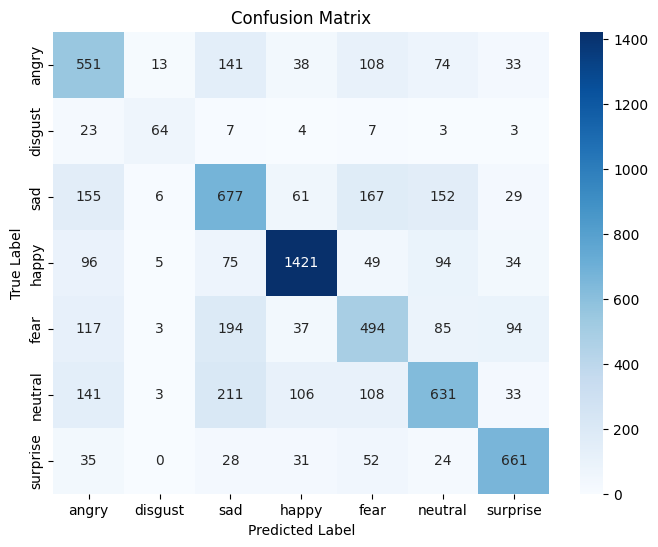

In [16]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTION_FOLDERS, yticklabels=EMOTION_FOLDERS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()